[View in Colaboratory](https://colab.research.google.com/github/sl2820/Deep_Learning_Study/blob/master/RNN_Stock_Prediction.ipynb)

# Stock Pricing Prediction with RNN

In [2]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
%matplotlib inline
tf.set_random_seed(0)
print ("Tensorflow Version is [%s]" % (tf.__version__))

Tensorflow Version is [1.11.0]


Before do anything, Upload the Raw Data file first

### Load Dataset

In [4]:
def MinMaxScaler(data):
  numerator = data - np.min(data,0)
  denominator = np.max(data,0) - np.min(data,0)
  return numerator / (denominator + 1e-7)
data = np.loadtxt('/content/data-02-stock_daily.csv', delimiter=',')
# Reverse Order (chronically ordered)
data = data[::-1] 
data = MinMaxScaler(data)
x = data
y = data[:,[-1]]
print("Shape of X is %s" % (x.shape,))
print("Shape of Y is %s" % (y.shape,))

Shape of X is (732, 5)
Shape of Y is (732, 1)


### Inside of Dataset 
Dataset has Five Items
  - Open / High / Low / Volume / Close
  
Objective is to predict 'Close' given 7 previous items

### Build a Dataset

In [5]:
timesteps = seq_len = 7  # Giveen 7 Previous Items
data_dim = 5   # 5 items for each data
dataX = []
dataY = []
for i in range(0,len(y)-seq_len):
  _x = x[i:i+seq_len]
  _y = y[i+seq_len]
  dataX.append(_x)
  dataY.append(_y)
  if i ==0:
    print ("   [INPUT]\n%s \n   ==>\n  [OUTPUT]\n%s" % (_x,_y))

print()
print ("Type    of     'dataX' is [%s]." %(type(dataX)))
print ("Length  of     'dataX' is [%d]." %(len(dataX)))
print ("Length  of  'dataX[0]' is [%s]." %(len(dataX[0])))
print()
print ("Type    of     'dataY' is [%s]." %(type(dataY)))
print ("Length  of     'dataY' is [%d]." %(len(dataY)))
print ("Length  of  'dataY[0]' is [%s]." %(len(dataY[0])))


   [INPUT]
[[2.13751054e-01 2.08179810e-01 1.91791832e-01 4.66075110e-04
  1.92092403e-01]
 [1.93935034e-01 2.03641926e-01 2.08664571e-01 2.98467330e-03
  1.96551555e-01]
 [2.10516454e-01 2.05289413e-01 2.03558748e-01 2.59926504e-04
  1.87749731e-01]
 [1.86678765e-01 2.09480567e-01 2.08781843e-01 0.00000000e+00
  2.17448151e-01]
 [3.06973882e-01 3.14634137e-01 2.18993665e-01 1.24764722e-02
  2.16981885e-01]
 [2.19142110e-01 2.63907214e-01 2.24686396e-01 4.56323384e-01
  2.24967473e-01]
 [2.33129931e-01 2.36419163e-01 1.62682724e-01 5.70171193e-01
  1.47442742e-01]] 
   ==>
  [OUTPUT]
[0.13289962]

Type    of     'dataX' is [<class 'list'>].
Length  of     'dataX' is [725].
Length  of  'dataX[0]' is [7].

Type    of     'dataY' is [<class 'list'>].
Length  of     'dataY' is [725].
Length  of  'dataY[0]' is [1].


### Split Data Train (70%) and Test (%30)

In [7]:
# Define a function for printing
def print_np(_name,_x):
  print ("Type of [%s] is [%s]" % (_name, type(_x)))
  print ("Shape of [%s] is %s" % (_name, _x.shape,))

  
# Actual process
train_size = int(len(dataY)*0.7)
test_size = len(dataY)-train_size
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])
print_np('trainX', trainX)
print_np('trainY', trainY)
print_np('testX', testX)
print_np('testY', testY)

Type of [trainX] is [<class 'numpy.ndarray'>]
Shape of [trainX] is (507, 7, 5)
Type of [trainY] is [<class 'numpy.ndarray'>]
Shape of [trainY] is (507, 1)
Type of [testX] is [<class 'numpy.ndarray'>]
Shape of [testX] is (218, 7, 5)
Type of [testY] is [<class 'numpy.ndarray'>]
Shape of [testY] is (218, 1)


### Train Parameters


In [0]:
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

### Define Model

In [9]:
# Placeholders
X = tf.placeholder(tf.float32, [None, seq_len, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# Build Model
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
print ("'X' LOOKS LIKE %s" % (X))
print ("'Y' LOOKS LIKE %s" % (Y))
print ("'OUTPUTS' LOOKS LIKE %s" % (outputs))

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
'X' LOOKS LIKE Tensor("Placeholder:0", shape=(?, 7, 5), dtype=float32)
'Y' LOOKS LIKE Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
'OUTPUTS' LOOKS LIKE Tensor("rnn/transpose_1:0", shape=(?, 7, 10), dtype=float32)


for above, Note that, **input to a RNN** should look like: **[Batch, Seq_Length, Data_Dim] **

### Add Dense Layer for Regression

In [11]:
#We use Last cell's output
Y_pred = tf.contrib.layers.fully_connected(outputs[:,-1], output_dim, activation_fn=None)
print("'Y_Pred' looks like %s" % (Y_pred))

'Y_Pred' looks like Tensor("fully_connected_1/BiasAdd:0", shape=(?, 1), dtype=float32)


### Define Operators

In [12]:
# Optimize
loss = tf.reduce_mean(tf.square(Y_pred -Y))
optm = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# RMSE   (Root mean square error)
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets-predictions)))
print ("Model Defined")

Model Defined


### Now, Run

In [15]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session (config = config)
init = tf.global_variables_initializer()
sess.run(init)

# Train
losses = []
for i in range (iterations):
  _, lossval = sess.run([optm,loss], feed_dict = {X: trainX, Y: trainY})
  losses.append(lossval)
  if i % 100 ==0:
    print ("[%d/%d] lossval: %.4f" % (i+1, iterations, lossval))

print ("Optimization Done")

[1/500] lossval: 0.0578
[101/500] lossval: 0.0014
[201/500] lossval: 0.0013
[301/500] lossval: 0.0011
[401/500] lossval: 0.0010
Optimization Done


### Plot Loss

Text(0.5,1,'Loss')

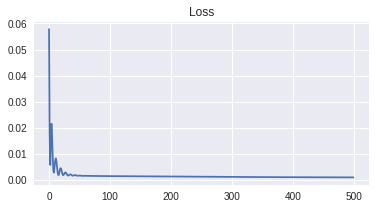

In [16]:
losslist = [_lossval for _lossval in losses]
plt.figure (figsize = (6,3))
plt.plot(losslist, label = 'With BN')
plt.title("Loss")

### Now, Test

In [17]:
test_predict = sess.run(Y_pred, feed_dict = {X: testX})
rmse = sess.run(rmse, feed_dict = {targets: testY, predictions: test_predict})
print_np('testX',testX)
print_np("test_predict", test_predict)
print ("RMSE: {}".format(rmse))

Type of [testX] is [<class 'numpy.ndarray'>]
Shape of [testX] is (218, 7, 5)
Type of [test_predict] is [<class 'numpy.ndarray'>]
Shape of [test_predict] is (218, 1)
RMSE: 0.02672998607158661


### Plot Predictions


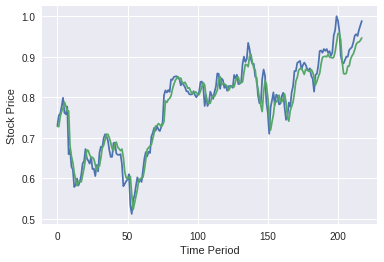

In [18]:

plt.plot(testY)
plt.plot(test_predict)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()